# Consistent Bayes: Improving Sampling
---

Copyright 2018 Michael Pilosov


### Import Libraries
_tested with python 3.6 on 01/26/18_

In [1]:
# Mathematics and Plotting
from HelperFuns import * # pyplot wrapper functions useful for visualizations, numpy, scipy, etc.
%matplotlib inline
from cbayes import sample, solve, distributions
# Interactivity
from ipywidgets import *
from sklearn import mixture

In [2]:
plt.rcParams.update({'font.size': 24})
plt.rcParams['figure.figsize'] = 20, 10

---
## Formulating the Inverse Problem
---
### Prior Information/Assumptions

* We assume that the true value $\lambda_0$ belongs to a parameter space $\Lambda$.


* Much like in the classical statistical Bayesian framework, we begin by encapsulating our pre-existing beliefs about our parameters in a distribution in a prior distribution on $\Lambda$, $\pi^{prior}_\Lambda$

### The Observed Density

* The observed density represents the uncertainty in an observation of a measurable quantity of interest map that takes input parameters and produces a vector in $\mathbb{R}^d$.


* While there are problem scenarios you can posit where the observed density corresponds to a normalized likelihood function from the statistical Bayesian approach, the quantity of interest may not necessarily just be the uncertainty in the measurement data. 


* If the quantity of interest is indeed a single direct measurement, then the likelihood is the observed. For example, for some true parameter $\lambda_0$ and model $u(\lambda, t)$, suppose your quantity of interest is defined as a single evaluation at some time $t_0$. The measurement uncertainty contained in that one measurement would constitute your observed density. 


* However, if we have a collection of observations, such as at $t_0, t_2, \dots, t_K$,  each of which is polluted by normally distributed noise, a common thing to do from Bayesian and Frequentist statistics would be to minimize the mean-or sum-squared error. If the sum squared error (SSE) is what we treat as our quantity of interest, the observed density on $\mathcal{D}$, denoted by $\pi^{obs}_{\mathcal{D}}(d)$, would be given by a $\chi^2_{K+1}$ distribution.


### The Posterior Density

* Let $\pi^{O(prior)}_{\mathcal{D}}(d)$ denote the push-forward of the prior density onto $\mathcal{D}$. Then, the posterior density on $\Lambda$ is given by

$$
    \pi^{post}_\Lambda(\lambda) := \pi^{prior}_\Lambda(\lambda)\frac{\pi^{obs}_{\mathcal{D}}(Q(\lambda))}{\pi^{O(prior)}_{\mathcal{D}}(Q(\lambda))}
$$

---
## Define your Map
_ Choose from one of the following example options, feel free to add your own _ 

$O_1(\lambda) = \sum_{i=1}^n \lambda_i$  

$O_2(\lambda) = \lbrace \lambda_0,\;\; \lambda_0 - \lambda_1 \rbrace$ 

$O_3(\lambda) = \lbrace \lambda_0,\;\; \lambda_0 - \lambda_1, \; \;\lambda_1^2 \rbrace$

$O_4(\lambda) = (1-x)^2 + (y - x^2)^2$  ( This is the [Rosenbrock Function](https://en.wikipedia.org/wiki/Rosenbrock_function) with $a=1$ and $b=100$. )

In [3]:
PtO_fun_choice = 4
global model_solves
model_solves = 0
def fun1(lam): # sum all params
    return np.sum(lam,axis=1)

def fun2(lam): # pull two params, linear combination.
    return np.array([ lam[:,0] ,lam[:,0]-lam[:,1]]).transpose()

def fun3(lam): # pull two params, linear combination.
    return np.array([ lam[:,0] ,lam[:,0]-lam[:,1], lam[:,1]**2 ]).transpose()

def rosenbrock(lam, ct=True):
    if ct: # this variable overrides count of model evaluations.
        global model_solves
        model_solves += lam.shape[0]
    output = (1.-lam[:,0])**2 + 100*(lam[:,1]-lam[:,0]**2.)**2
    return output.reshape(-1,1)
    
if PtO_fun_choice == 1:
    PtO_fun = fun1
elif PtO_fun_choice == 2:
    PtO_fun = fun2
elif PtO_fun_choice == 3:
    PtO_fun = fun3
elif PtO_fun_choice == 4:
    PtO_fun = rosenbrock
else:
    raise( ValueError('Specify Proper PtO choice!') )

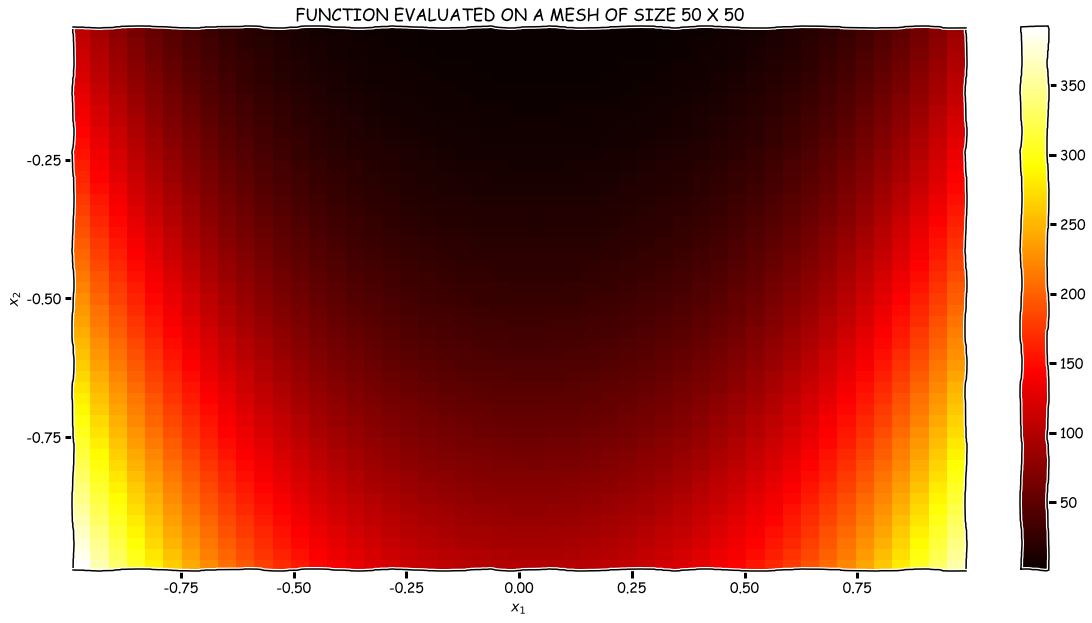

In [4]:
plt.xkcd(scale=1, length=1000, randomness=100)
nbins = 50
mins = np.array([-1, -1])
maxs = np.array([1, 0])
tempgrid = grid(nbins, mins, maxs)
tempZ = rosenbrock(tempgrid, ct=False) # we dont count this visual against our computational budget.
xi = tempgrid[:,0].reshape(nbins,nbins)
yi = tempgrid[:,1].reshape(nbins,nbins)
zi = tempZ.reshape(nbins,nbins)
plt.yticks(np.linspace(-1,0,5))
plt.xticks(np.linspace(-1,1,9))
plt.pcolormesh(xi,yi,zi,cmap='hot')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.colorbar()
plt.title('Function Evaluated on a Mesh of size {} x {}'.upper().format(nbins, nbins))
# plt.axis('equal')
plt.show()

--- 

# Sample from $\Lambda$
_Here we implement uniform random priors on the unit hypercube_

In [237]:
input_dim = 2 # Specify input space dimension (n)
num_samples = int(5E3) # number of input samples (N)
s_set = sample.sample_set(size=(num_samples, input_dim))
model_solves = 0
if PtO_fun_choice == 1:
    s_set.set_dist('normal', {'loc': 0, 'scale': 1}, dim=0)
elif PtO_fun_choice == 2:
    s_set.set_dist('normal', {'loc': 0, 'scale': 1}, dim=0)
elif PtO_fun_choice == 3:
    s_set.set_dist('normal', {'loc': 0, 'scale': 1}, dim=0)
elif PtO_fun_choice == 4: # rosenbrock
    s_set.set_dist('uniform', {'loc': -1, 'scale': 2}, dim=0)
    s_set.set_dist('uniform', {'loc': -1, 'scale': 1}, dim=1)              
s_set.generate_samples()

lam = s_set.samples # create a pointer for ease of reference later with plotting.

### Visualize Prior 

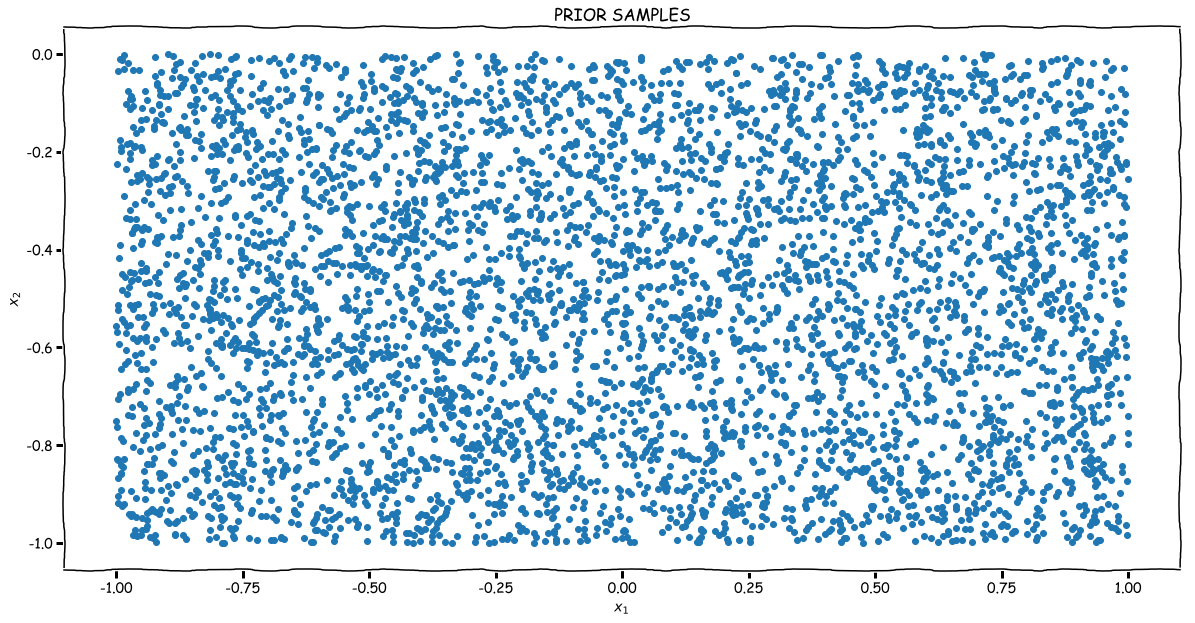

In [238]:
# widgets.interactive(pltdata, data = fixed(lam), inds = fixed(None), 
#                     N = widgets.IntSlider(value=500, min = 100, max=5000, step=100, continuous_update=False), 
#                     eta_r = fixed(None), space=fixed(0.05), svd=widgets.Checkbox(value=False), color=widgets.Text(value="orange"),
#                     view_dim_1 = widgets.IntSlider(value=0, min=0, max=input_dim-1, step=1, continuous_update=False), 
#                     view_dim_2 = widgets.IntSlider(value=input_dim-1, min=0, max=input_dim-1, step=1, continuous_update=False))
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Prior Samples'.upper())
plt.scatter(lam[:,0], lam[:,1])
plt.show()

---
# Compute Data Space $O(\Lambda) = \mathcal{D}$ 

Format: `(n_dims, n_samples)`  

In [239]:
p_set = sample.map_samples_and_create_problem(s_set, PtO_fun)
D = p_set.output.samples

# this is how we handle trying to infer the dimension based on what the map put out.
try:
    output_dim = D.shape[1] # if your function was coded correctly, you should have an (n, d) data space.
except IndexError:
    print(Warning("Warning: Your map might be returning the wrong dimensional data."))
    try:
       output_dim = D.shape[0] 
    except IndexError:
        print(Warning("Warning: Guessing it's 1-dimensional."))
        output_dim = 1
print('dimensions :  lambda = '+str(lam.shape)+'   D = '+str(D.shape) )

dimensions :  lambda = (5000, 2)   D = (5000, 1)


# Compute Push-Forward of the Prior $P_{O(\Lambda)}$
_ ... i.e. Characterize the Data Space_

In [240]:
# Interactive Marginal Visualization
p_set.compute_pushforward_dist(method='g')
p_set.compute_pushforward_dist(method='s', kwds={'kernel': 'gaussian', 'bandwidth': 20})
pf_dist = p_set.pushforward_dist

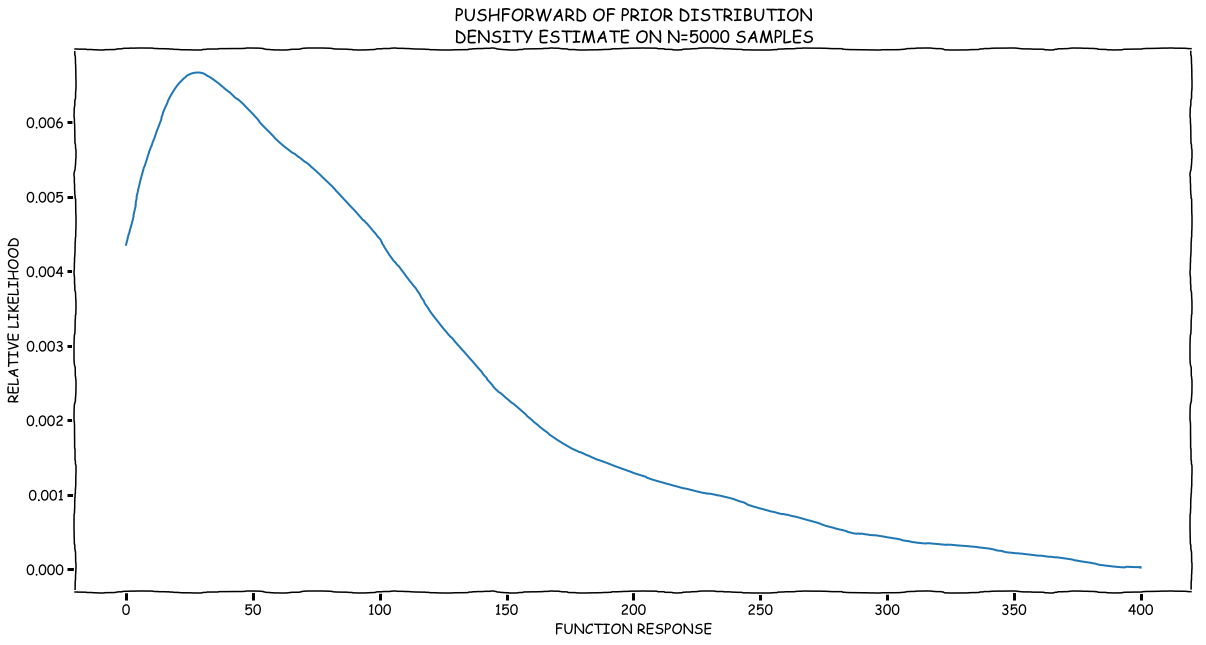

In [241]:
# widgets.interactive(pltdata, data = fixed(pf_dist), inds = fixed(None), 
#         N = widgets.IntSlider(value=500, min = 100, max=5000, step=100, continuous_update=False), 
#         eta_r = fixed(None), space=fixed(0.05), svd=fixed(False), color=widgets.Text(value="brown"),
#         view_dim_1 = widgets.IntSlider(value=0, min=0, max=output_dim-1, step=1, continuous_update=False), 
#         view_dim_2 = widgets.IntSlider(value=output_dim-1, min=0, max=output_dim-1, step=1, continuous_update=False))
dd = np.linspace(0,400,1000)
dde = p_set.pushforward_dist.pdf(dd)
plt.plot(dd,dde)
plt.ylabel('relative likelihood'.upper())
plt.xlabel('Function Response'.upper())
plt.title('Pushforward of Prior Distribution\nDensity Estimate on N={} Samples'.upper().format(num_samples))
plt.show()

# Define Observed Probability Measure $P_\mathcal{D}$

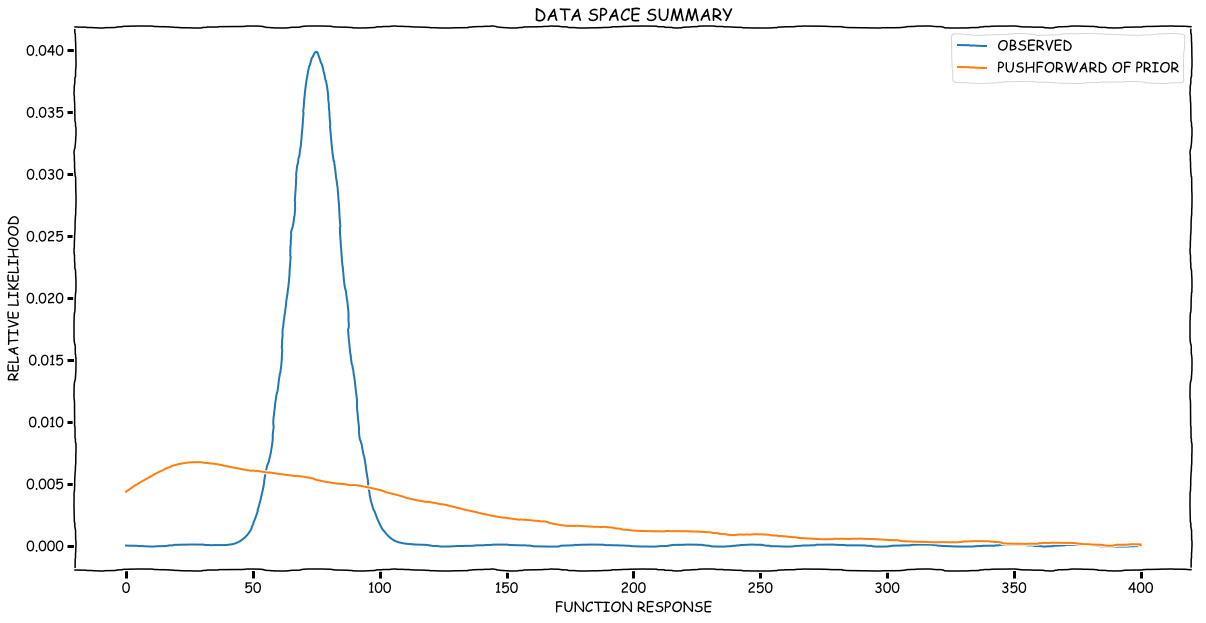

In [242]:
if PtO_fun_choice == 4:
    p_set.set_observed_dist('norm', {'loc': 75, 'scale': 10}, dim=0) # FOR ROSENBROCK

elif PtO_fun_choice == 3:
#         p_set.set_observed_dist('normal', {'loc':[0, 0, 0], 'scale':[0.5, 0.25, 1]}) # better for function choice = 2
    p_set.set_observed_dist('uniform', {'loc':[-0.5, -0.5, -0.5], 'scale':[1, 1, 1]}, dim=0) # better for function choice = 2

elif PtO_fun_choice == 2:
    p_set.set_observed_dist('uniform', {'loc': 0, 'scale': 1}, dim=0) # default is normal based on the data space # for function choice = 1
    p_set.set_observed_dist('uniform', {'loc': 0, 'scale': 0.25}, dim=1) 
elif PtO_fun_choice == 1:
    p_set.set_observed_dist('uni', {'loc':0, 'scale':0.3}, dim=0) # default is normal based on the data space # for function choice = 1

obs_dist = p_set.observed_dist # this is define a pointer for ease of reference.

# widgets.interactive(pltdata, data = fixed(obs_dist), inds = fixed(None), 
#         N = widgets.IntSlider(value=500, min = 100, max=5000, step=100, continuous_update=False), 
#         eta_r = fixed(None), space=fixed(0.05), svd=fixed(False), color=widgets.Text(value="wine"),
#         view_dim_1 = widgets.IntSlider(value=0, min=0, max=output_dim-1, step=1, continuous_update=False), 
#         view_dim_2 = widgets.IntSlider(value=output_dim-1, min=0, max=output_dim-1, step=1, continuous_update=False))
ddd = np.linspace(50,150,1000)
ddd = dd
plt.plot(ddd, p_set.observed_dist.pdf(ddd), label='OBSERVED')
plt.plot(ddd, dde, label='PUSHFORWARD OF PRIOR')
plt.legend(loc='upper right')
plt.ylabel('relative likelihood'.upper())
plt.xlabel('Function Response'.upper())
plt.title('Data Space Summary'.upper())
plt.show()

---

At this point we have performed the computations we need to. We have evaluated the input points through our map and performed a KDE on them. It would be useful at this point to save this object and/or its evaluation at every point in the data space for later re-use. Doing so here would be an appropriate place. 

--- 

# Accept/Reject Sampling of Posterior

Since we have already used the samples in our prior to compute the pushforward density, we can re-use these with an accept/reject algorithm to get a set of samples generated from the posterior according to the solution of the stochastic inverse problem as outlined in the Consistent Bayes formulation. 

In [243]:
p_set.set_ratio()
eta_r = p_set.ratio
solve.problem(p_set)

In [244]:
accept_inds = p_set.accept_inds
lam_accept = p_set.input.samples[accept_inds,:]
num_accept = len(accept_inds)
print('Number accepted: %d = %2.2f%%'%(num_accept, 100*np.float(num_accept)/num_samples))

Number accepted: 696 = 13.92%


## Visualize Posterior Density
### (Visualize Accept/Reject Samples)


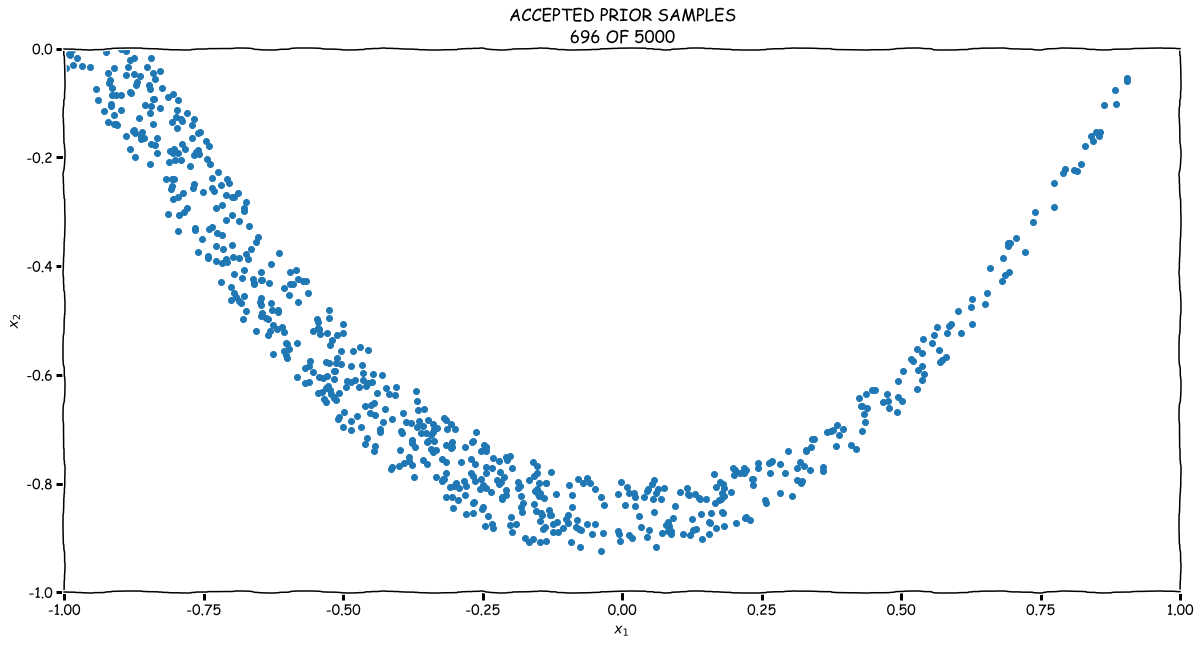

In [245]:
# widgets.interactive(pltdata, data = fixed(lam), inds = fixed(accept_inds), 
#         N = widgets.IntSlider(value=num_accept/2, min = 2, max=num_accept+1, step=1, continuous_update=False), 
#         eta_r = fixed(None), space=fixed(0.05), svd=widgets.Checkbox(value=False), color=widgets.Text(value="orange"),
#         view_dim_1 = widgets.IntSlider(value=0, min=0, max=input_dim-1, step=1, continuous_update=False), 
#         view_dim_2 = widgets.IntSlider(value=input_dim-1, min=0, max=input_dim-1, step=1, continuous_update=False))

# You will visualize the accepted samples in a subset of size N of the input samples. 
# This is mostly for faster plotting, but also so you can see the progression of accepted sampling in the algorithm.
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.xlim([-1,1])
plt.ylim([-1,0])
plt.title('Accepted Prior Samples\n{} of {}'.upper().format(num_accept, num_samples))
plt.scatter(lam_accept[:,0], lam_accept[:,1])
plt.show()

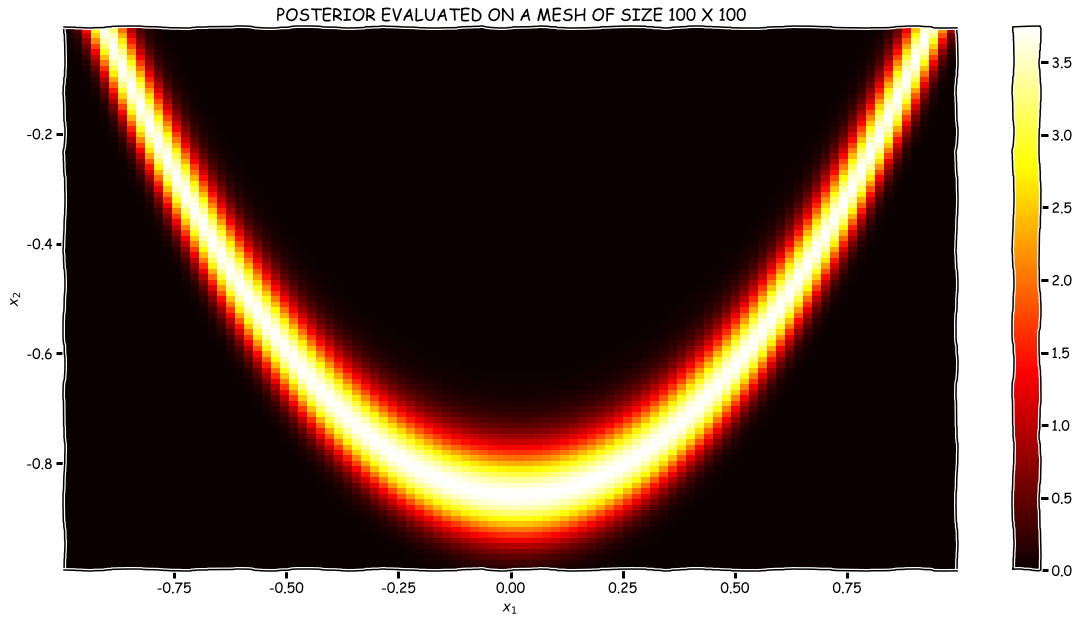

In [246]:
nbins = 100
tempgrid = grid(nbins, mins, maxs)
xi = tempgrid[:,0].reshape(nbins,nbins)
yi = tempgrid[:,1].reshape(nbins,nbins)
zzi = p_set.evaluate_posterior(tempgrid)
model_solves -= nbins**2 # we have to manually override this to avoid changing the sample object.
plt.pcolormesh(xi, yi, zzi.reshape(nbins,nbins), cmap='hot')
plt.title('Posterior Evaluated on a Mesh of size {} x {}'.upper().format(nbins, nbins))
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.colorbar()
plt.show()

Percent accepted: 13.61


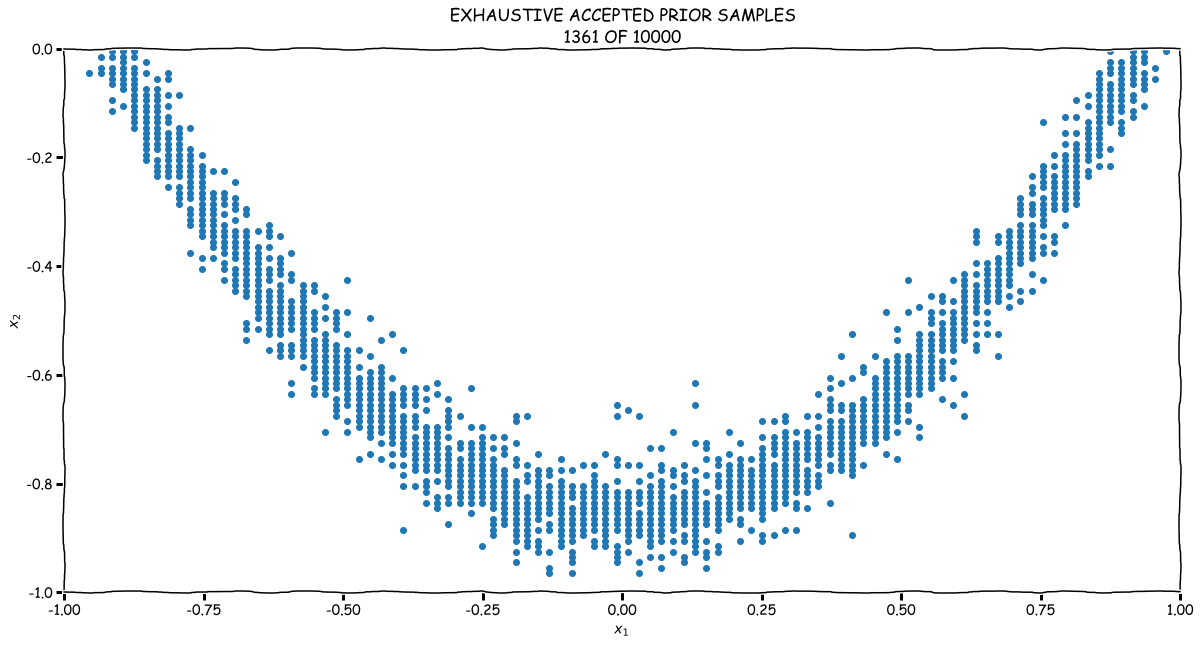

In [247]:
nbins = 100
new_inputs = grid(nbins, mins, maxs)
new_outputs = PtO_fun(new_inputs)
new_ratio = p_set.compute_ratio(new_outputs)
model_solves -= nbins*nbins
new_inds = solve.perform_accept_reject(new_inputs, new_ratio)
num_accept = len(new_inds)
new_accept = new_inputs[new_inds,:]
print('Percent accepted:', 100*len(new_inds)/(nbins*nbins))
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.xlim([-1,1])
plt.ylim([-1,0])
plt.title('Exhaustive Accepted Prior Samples\n{} of {}'.upper().format(num_accept, nbins*nbins))
plt.scatter(new_accept[:,0], new_accept[:,1])
plt.show()

---
### Now what? 

Well, we can...

## _Visualize the Quality of our SIP Solution by Comparing it to the Observed_
_We compare the push-forward of the posterior using accepted samples against the observed density_  
_(SIP = Stochastic Inverse Problem)_
### Observed:

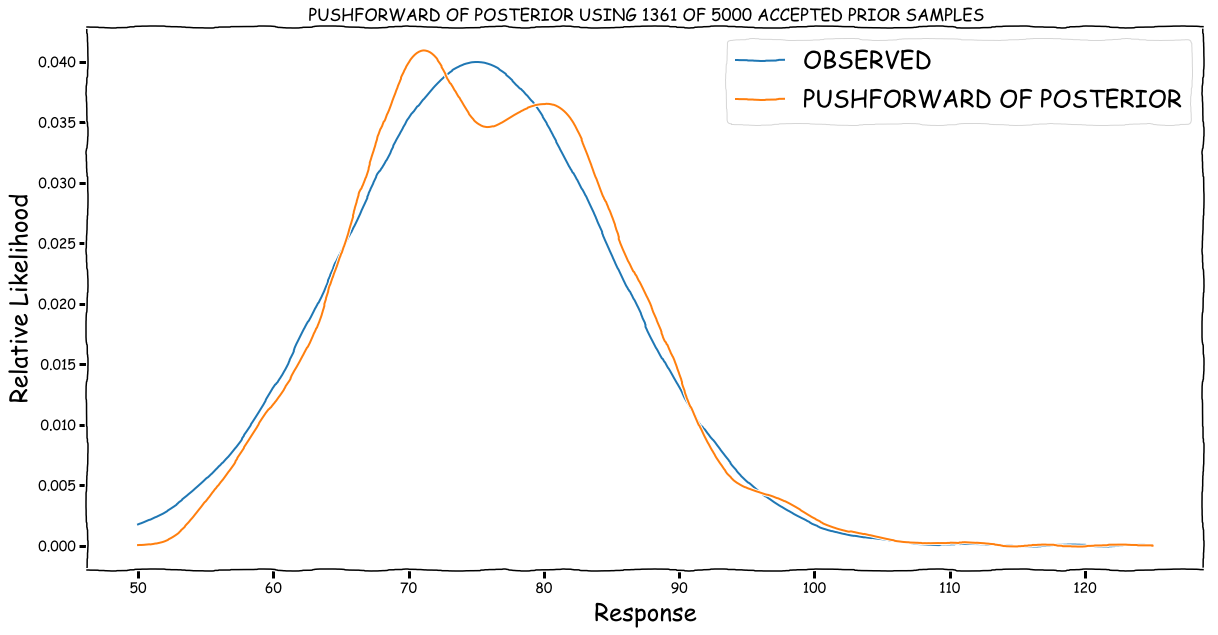

In [248]:
xxi = np.linspace(50,125,1000)
plt.plot(xxi, p_set.observed_dist.pdf(xxi), label='OBSERVED')
dy = distributions.skde(data=p_set.output.samples[accept_inds,:], **{'kernel': 'gaussian', 'bandwidth': 2})
plt.plot(xxi, dy.pdf(xxi), label='PUSHFORWARD OF POSTERIOR')
plt.legend(loc='upper right',fontsize=24)
plt.xlabel('Response',fontsize=24)
plt.ylabel('Relative Likelihood',fontsize=24)
plt.title('Pushforward of Posterior using {} of {} Accepted Prior Samples'.upper().format(num_accept, num_samples))
plt.show()

## What would happen if we used an exhaustive search?

# Use Scikit-learn's prepackaged Gaussian Mixture Models on our accepted samples

In [259]:
model_solves = 1000

In [260]:
X = lam_accept
# X = np.vstack([lam_accept, lam_accept])
Y = p_set.output.samples[accept_inds,:]
gmm = mixture.GaussianMixture(n_components=6, covariance_type='full',
                              max_iter=100).fit(X)
n_samps = 5E3
new_inputs = gmm.sample(n_samps)[0]
new_outputs = PtO_fun(new_inputs)
# new_ratio = p_set.observed_dist.pdf(new_outputs)/p_set.pushforward_dist.pdf(new_outputs)
new_ratio = p_set.compute_ratio(new_outputs)
new_inds = solve.perform_accept_reject(new_inputs, new_ratio)
new_accept = new_inputs[new_inds,:]
print('Percent accepted:', 100*len(new_inds)/n_samps)

Percent accepted: 76.04


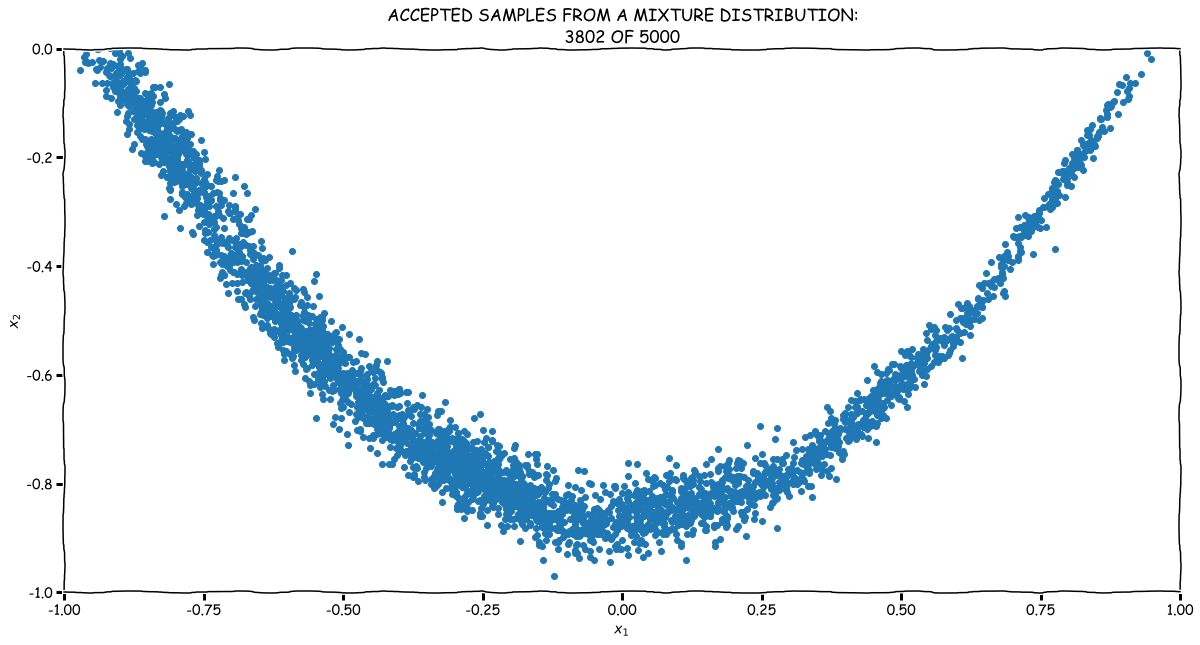

In [261]:
plt.scatter(new_accept[:,0], new_accept[:,1])
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.xlim([-1,1])
plt.ylim([-1,0])
plt.title('Accepted Samples from a Mixture Distribution:\n{} of {}'.upper().format(len(new_inds), int(n_samps)))
plt.show()

## Now lets add these new accepted Samples in and continue onwards.

In [262]:
XX = np.vstack([X, new_accept])
YY = np.vstack([Y, new_outputs[new_inds,:]])

In [263]:
n_samps = 1E3
while model_solves < 10000:
    gmm2 = mixture.GaussianMixture(n_components=4, covariance_type='full',
                                  max_iter=100).fit(XX)
    new_inputs = gmm2.sample(n_samps)[0]
    new_outputs = PtO_fun(new_inputs)
    new_ratio = p_set.compute_ratio(new_outputs)
    new_inds = solve.perform_accept_reject(new_inputs, new_ratio)
    new_accept = new_inputs[new_inds,:]
    print('Percent accepted:', 100*len(new_inds)/n_samps)
    XX = np.vstack([XX, new_accept])
    YY = np.vstack([YY, new_outputs[new_inds,:]])
print('Out of Samples. Number of Model Solves: ', model_solves)

Percent accepted: 77.5
Percent accepted: 80.7
Percent accepted: 81.5
Percent accepted: 81.9
Out of Samples. Number of Model Solves:  10000


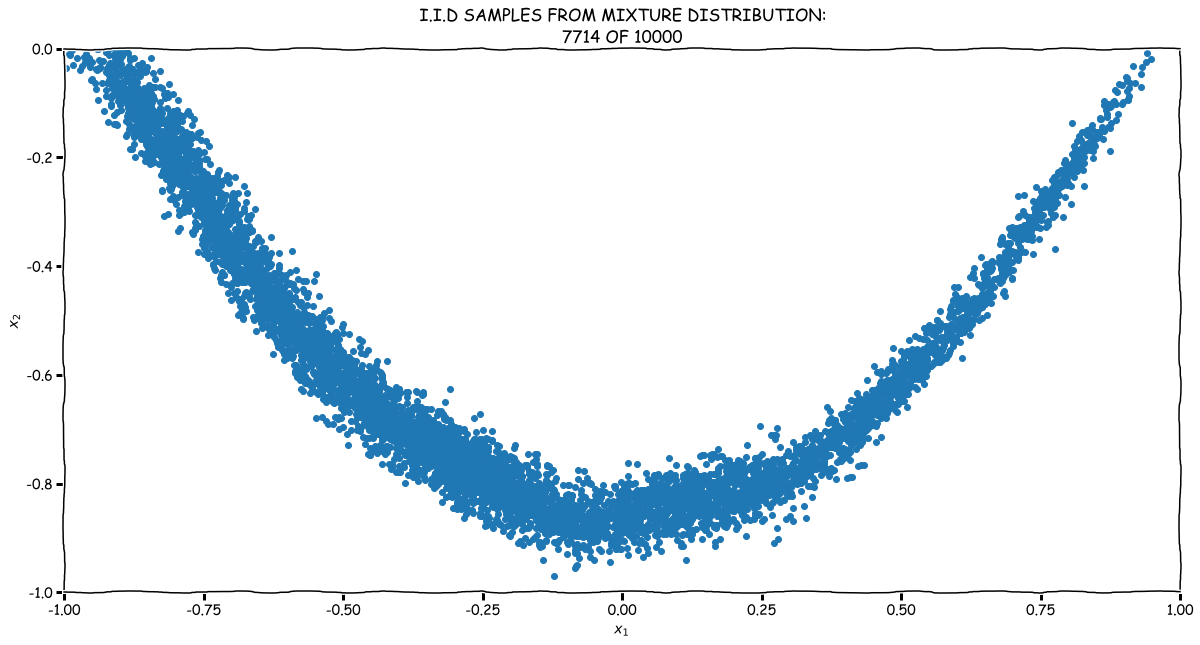

In [264]:
## XX now represents an exploration based on steps of 100 samples from Gaussian Mixture Models.
plt.scatter(XX[:,0], XX[:,1])
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.xlim([-1,1])
plt.ylim([-1,0])
plt.title('i.i.d Samples from Mixture Distribution:\n{} of {}'.upper().format(XX.shape[0], int(model_solves)))
plt.show()

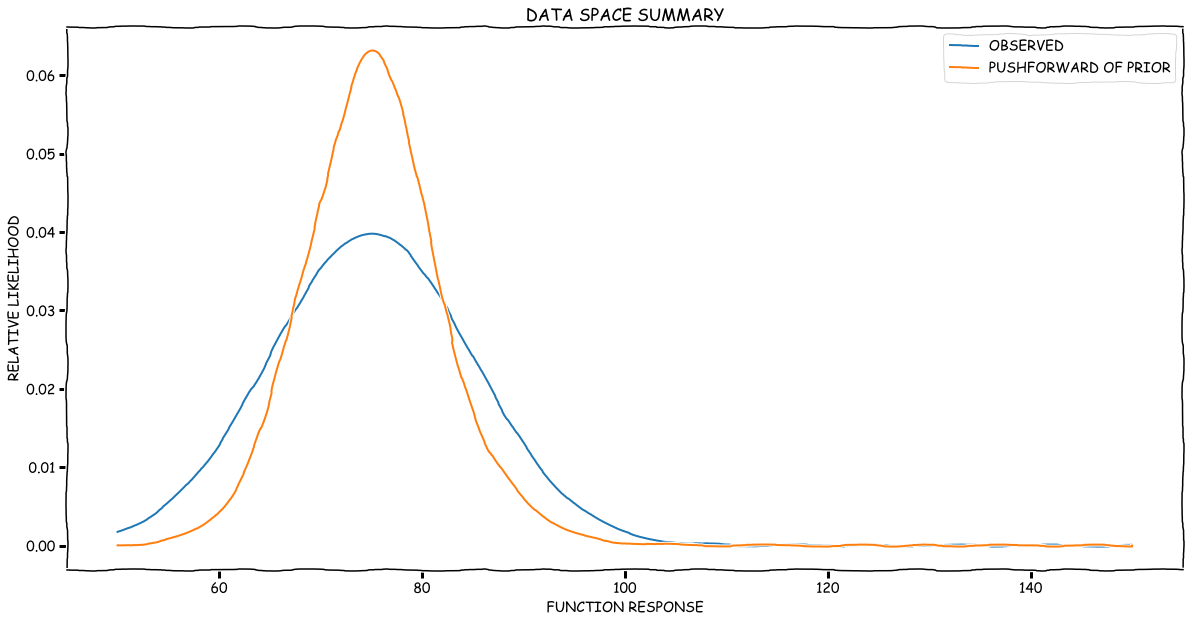

In [265]:
ddd = np.linspace(50,150,1000)
dy = distributions.skde(YY, **{'kernel': 'gaussian', 'bandwidth': 2})
plt.plot(ddd, p_set.observed_dist.pdf(ddd), label='OBSERVED')
plt.plot(ddd, dy.pdf(ddd), label='PUSHFORWARD OF PRIOR')
plt.legend(loc='upper right')
plt.ylabel('relative likelihood'.upper())
plt.xlabel('Function Response'.upper())
plt.title('Data Space Summary'.upper())
plt.show()

In [24]:
model_solves

10000

In [25]:
raise(AttributError)

NameError: name 'AttributError' is not defined

In [ ]:
# widgets.interactive(pltdata, data = fixed(obs_dist), inds = fixed(None), 
#         N = widgets.IntSlider(value=500, min = 100, max=5000, step=100, continuous_update=False), 
#         eta_r = fixed(None), space=fixed(0.05), svd=fixed(False), color=widgets.Text(value="wine"),
#         view_dim_1 = widgets.IntSlider(value=0, min=0, max=output_dim-1, step=1, continuous_update=False), 
#         view_dim_2 = widgets.IntSlider(value=output_dim-1, min=0, max=output_dim-1, step=1, continuous_update=False))

## Pushforward of Posterior:

In [ ]:
# widgets.interactive(pltdata, data = fixed(D), inds = fixed(accept_inds), 
#         N = widgets.IntSlider(value=num_accept/2, min = 2, max=num_accept-1, step=1, continuous_update=False), 
#         eta_r = fixed(None), space=fixed(0.05), svd=fixed(False), color=widgets.Text(value="eggplant"),
#         view_dim_1 = widgets.IntSlider(value=0, min=0, max=output_dim-1, step=1, continuous_update=False), 
#         view_dim_2 = widgets.IntSlider(value=output_dim-1, min=0, max=output_dim-1, step=1, continuous_update=False))


# Using the Posterior in Other Ways...

## Utilizing a KDE of the Posterior
### _Use KDE of posterior to generate new samples_

In [ ]:
post_dens_kde = distributions.gkde(lam_accept)
n = 5000 # number of new samples to generate using the KDE
new_inputs = post_dens_kde.rvs(n)

widgets.interactive(pltdata, data = fixed(new_inputs), inds = fixed(None), 
        N = widgets.IntSlider(value=1000, min = 1, max=5000, step=100, continuous_update=False), 
        eta_r = fixed(None), space=fixed(0.05), svd=widgets.Checkbox(value=False), color=widgets.Text(value="tiffany blue"),
        view_dim_1 = widgets.IntSlider(value=0, min=0, max=input_dim-1, step=1, continuous_update=False), 
        view_dim_2 = widgets.IntSlider(value=input_dim-1, min=0, max=input_dim-1, step=1, continuous_update=False))

# plt.show()

These don't do an excellent job of simulating the accepted samples per say. 

### _Perhaps these do a decent job resolving the observed density? Let's push-forward the samples from the KDE of the Posterior through our map and see:_

In [ ]:
new_outputs = PtO_fun(new_inputs).reshape((n, output_dim))
widgets.interactive(pltdata, data = fixed(new_outputs), inds = fixed(None), 
        N = widgets.IntSlider(value=1000, min = 1, max=5000, step=100, continuous_update=False), 
        eta_r = fixed(None), space=fixed(0.05), svd=widgets.Checkbox(value=False), color=widgets.Text(value="cyan"),
        view_dim_1 = widgets.IntSlider(value=0, min=0, max=output_dim-1, step=1, continuous_update=False), 
        view_dim_2 = widgets.IntSlider(value=output_dim-1, min=0, max=output_dim-1, step=1, continuous_update=False))


### _More likely, we would use the KDE instead to generate proposal samples for accept/reject._

In [ ]:
# # This also outlines the tricks we have to do to handle multi-dimensional parametric distributions. 
# new_ratios = p_set.compute_ratio(new_outputs)
# new_inds = solve.perform_accept_reject(new_inputs, new_ratios)
# new_accepted_samples = new_inputs[new_inds,:]
# new_num_accept = new_accepted_samples.shape[0]
# print("Num. Accepted = %d out of %d (%2.2f%%)"%(new_num_accept, n, 100*new_num_accept/n))

In [ ]:
# widgets.interactive(pltdata, data = fixed(new_inputs), inds = fixed(new_inds), 
#         N = widgets.IntSlider(value=new_num_accept/2, min = 1, max=new_num_accept, step=1, continuous_update=False), 
#         eta_r = fixed(None), space=fixed(0.05), svd=widgets.Checkbox(value=False), color=widgets.Text(value="tiffany blue"),
#         view_dim_1 = widgets.IntSlider(value=0, min=0, max=input_dim-1, step=1, continuous_update=False), 
#         view_dim_2 = widgets.IntSlider(value=input_dim-1, min=0, max=input_dim-1, step=1, continuous_update=False))


## Use the Posterior to Construct a Piecewise-Defined Parametric Mixture Distribution

_The premise here is to partition the parameter space into affine subspaces (clusters) using the accepted samples. Then, perform singular value decompositions to decompose each subspace into its natural axes. Once this is achieved, we use the projections of the samples in each cluster onto the respective sets of axes in order to fit an parametric distribution. Each one is defined as the product of the one-dimensional marginal distributions that were determined to be the best fit for the projected samples on each axis. Finally, the mixture distribution is weighted according to the proportions of samples in each cluster._

This is just a high-dimensional approximation to a density. Likely a poor one. We may use this approach to construct an approximate pushforward disribution by applying the same principles to mapped samples in the data space. _More on that later._

_Ex:_ If you have $K$ clusters in an $n$-dimensional parameter space, you have to fit $n\times K$ parameteric distributions. ($n$ axes for each of the $K$ clusters). The density of any value will then be evaluated as follows:


    1. Determine which cluster the sample belongs to.
    2. Project the sample onto each orthogonal axis that you got from the SVD
    3.  Evaluate the one-dimensional parametric distributions that we found to be the best fit at this projection value.
    4.  The product of these two weighted by the proportion of this cluster compared to the total number of samples is then the density value that is returned.


In [ ]:
import scipy.io as sio
import numpy as np

# import relevant ML modules
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.cluster import KMeans


In [ ]:
rstate = 42 # random state.
sc = StandardScaler()

X = lam_accept
X_sc = sc.fit_transform(X) # scale data to normalized

# train_size = 0.2

# X_train, X_test = \
#     train_test_split(X, test_size= 1.0 - train_size, random_state=rstate)

# sc = StandardScaler() # instantiate class which keeps track of scaling info.
# X_train_sc = sc.fit_transform(X_train)
# X_test_sc = sc.transform(X_test)
X_train_sc = X_sc # use the entirety of the accepted samples. The downside of this is that you don't 

h = 0.05 # mesh parameter for plotting
buff = 0.1 # buffer for plotting
x_min, x_max = X_train_sc[:, 0].min() - buff, X_train_sc[:, 0].max() + buff
y_min, y_max = X_train_sc[:, 1].min() - buff, X_train_sc[:, 1].max() + buff
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h)) # mesh params unscaled

num_clusters = 8
kmeans = KMeans(n_clusters=num_clusters, random_state=rstate).fit(X_train_sc)

from matplotlib.colors import ListedColormap
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.neural_network import MLPClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
# from sklearn.gaussian_process import GaussianProcessClassifier
# from sklearn.gaussian_process.kernels import RBF
# from sklearn.tree import DecisionTreeClassifier%matplotlib inline

# from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# from sklearn.naive_bayes import GaussianNB
# kmeans.labels_
# kmeans.cluster_centers_
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
# score = kmeans.score(X_test_sc)

In [ ]:
# %matplotlib inline
# plt.rcParams['figure.figsize'] = (30, 10)
plt.figure()

ax = plt.subplot(1,2,1)

# Put the result into a color plot
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=plt.cm.PuRd, alpha=.8)
ax.scatter(X_train_sc[:,0], X_train_sc[:,1])
# ax.scatter(X_test_sc[:,0], X_test_sc[:,1], c='k', alpha=0.05)
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_title('KMeans', fontsize=24)
# ax.text(xx.max() - buff, yy.min() + buff, ('%.2f' % score).lstrip('0'), size=25, horizontalalignment='right')
plt.show()

In [ ]:
print(kmeans.cluster_centers_[0])
# svd
labels = kmeans.labels_
# for k in range(num_clusters): # for each cluster k
D = { k: {'center': sc.inverse_transform( kmeans.cluster_centers_[k] ), 
         'samples': lam_accept[labels == k, :]} for k in range(np.unique(labels).size) }

# print out what D is holding
# num_samps = 2
# for k in D.keys():
#     print('index:', k, '\ncenter:', D[k]['center'], 
#           '\nfirst few samples:\n', D[k]['samples'][0:num_samps,:], '\n')


In [ ]:
def lcl_pca(D):
    # the keys of the dictionary are labels for the clusters
    dim = len(D[0]['center'])
    for k in D.keys():
        lam_local = D[k]['samples']
        num_local_samples = len(lam_local)
        c = D[k]['center']
        L = lam_local - c # center the samples at the origin in order to perform SVD
        S = np.linalg.svd(L)
        B = S[2] # grab the eigenbasis for the subspace
        # now we project our samples onto this orthonormal basis (hence no denominator in projection formula)
        D[k]['proj_samples'] = {}
        for d in range(dim):
            Lp =  [np.inner( B[:,d], L[i,:])*B[:,d] for i in range(num_local_samples) ]
            Lp = np.array(Lp) + c
            D[k]['proj_samples'][d] = Lp # store the projections as a dictionary in a new key
#     return D # dictionaries are passed by reference, so no need to return anything?

### Perform Projections on dictionary object that holds our clusters.

In [ ]:
lcl_pca(D)

### Visualize Results

In [ ]:
k=1
c = D[k]['center']
plt.figure()
for d in D[k]['proj_samples'].keys(): # for each axis
    lam_local = D[k]['samples']
    plt.scatter(lam_local[:,0], lam_local[:,1], s=15, alpha=0.3)
    lam_local_proj = D[k]['proj_samples'][d] # grab projected samples3
    plt.scatter(lam_local_proj[:,0], lam_local_proj[:,1], c='k', s=5, alpha=0.4)
    plt.scatter(c[0], c[1], s=200, c='k')
plt.axis('equal')
plt.show()

In [ ]:


plt.figure()
for k in D.keys(): # for each subspace
    lam_local = D[k]['samples']
    plt.scatter(lam_local[:,0], lam_local[:,1], s=15, alpha=0.3)
    c = D[k]['center']
    for d in D[k]['proj_samples'].keys(): # for each axis
        lam_local_proj = D[k]['proj_samples'][d] # grab projected samples
        plt.scatter(lam_local_proj[:,0], lam_local_proj[:,1], c='k', s=5, alpha=0.4)
        plt.scatter(c[0], c[1], s=200, c='k')
plt.axis('equal')
plt.show()

### Fit Parametric Distributions

In [ ]:
prior_type = 'uniform'
obs_type = 'normal'
oberved_density = sstats.norm(loc=100., scale=6.)
prior_density = sstats.uniform(loc=-1, scale = 2)

def fit_dist(D, prior_type, ob_type):
    handles = ['pr', 'ob']
    for k in D.keys():
        D[k]['parametric'] = {d: {dist: {'loc': None, 'scale': None, 'fit': None} for dist in handles}  
                              for d in D[k]['proj_samples'].keys() }
#         print( D[k]['parametric'] )
        for d in D[k]['proj_samples'].keys(): 
            lcl_proj_samps = D[k]['proj_samples'][d][:,d]
            
            for idx, dist in enumerate([prior_type, ob_type]): # we have to figure out which axis is associated with distribution
                if dist == 'normal':
                    lcl_loc = np.mean(lcl_proj_samps)
                    lcl_scale = np.std(lcl_proj_samps) # std or var? I think std
                    D[k]['parametric'][d][ handles[idx] ]['loc'] = lcl_loc
                    D[k]['parametric'][d][ handles[idx] ]['scale'] = lcl_scale
                    D[k]['parametric'][d][ handles[idx] ]['fit'] = sstats.kstest(lcl_proj_samps,  sstats.norm(loc=lcl_loc, scale=lcl_scale).cdf)[1]
                elif dist == 'uniform':
                    lcl_loc = np.min(lcl_proj_samps) # left endpoint
                    lcl_scale = np.max(lcl_proj_samps) - lcl_loc # interval length
                    D[k]['parametric'][d][ handles[idx] ]['loc'] = lcl_loc
                    D[k]['parametric'][d][ handles[idx] ]['scale'] = lcl_scale
                    D[k]['parametric'][d][ handles[idx] ]['fit'] = sstats.kstest(lcl_proj_samps,  sstats.uniform(loc=lcl_loc, scale=lcl_scale).cdf)[1]
               
        # now that we've computed all the test stats for this cluster, we decide which is which
        # figure out which dimension fits the oberved best and prior best:
        ob_fits = [D[k]['parametric'][d]['ob']['fit'] for d in D[k]['proj_samples'].keys() ]
        pr_fits = [D[k]['parametric'][d]['pr']['fit'] for d in D[k]['proj_samples'].keys() ]
        
        # this loop will select the best fit, but sometimes that means the mixture might end up being ob/ob... which we dont want.
#         for d in D[k]['proj_samples'].keys(): 
#             # if the prior fits better than the ob:
#             if D[k]['parametric'][d][ handles[0] ]['fit'] > D[k]['parametric'][d][ handles[1] ]['fit']:
#                 D[k]['parametric'][d]['dist'] = {'type': prior_type, 
#                                                  'loc': D[k]['parametric'][d][ handles[0] ]['loc'],
#                                                  'scale': D[k]['parametric'][d][ handles[0] ]['scale']}
#             else:
#                 D[k]['parametric'][d]['dist'] = {'type': ob_type, 
#                                                  'loc': D[k]['parametric'][d][ handles[1] ]['loc'],
#                                                  'scale': D[k]['parametric'][d][ handles[1] ]['scale']}
            

In [ ]:
k = 1
# lcl_proj_samps = D[k]['proj_samples'][d]
fit_dist(D, prior_type, obs_type)
[D[k]['parametric'][d]['ob']['fit']  for d in D[k]['proj_samples'].keys() ]

In [ ]:
[D[k]['parametric'][d]['pr']['fit']  for d in D[k]['proj_samples'].keys() ]

In [ ]:
k, d = 1, 1
# lcl_proj_samps = D[k]['proj_samples'][d]
fit_dist(D, prior_type, obs_type)
D[k]['parametric'][d]

## Perform a second round by Adding in New Accepted Samples

In [ ]:

XX = new_inputs[new_inds,:]
gmm2 = mixture.GaussianMixture(n_components=4, covariance_type='full',
                              max_iter=100).fit(XX)
n_samps = 1E4
new_inputs = gmm.sample(n_samps)[0]
new_outputs = PtO_fun(new_inputs)
new_ratio = p_set.compute_ratio(new_outputs)
new_inds = solve.perform_accept_reject(new_inputs, new_ratio)
print('Percent accepted:', 100*len(new_inds)/n_samps)

In [ ]:
plt.scatter(new_inputs[new_inds,0], new_inputs[new_inds,1])
plt.show()

In [ ]:
p_set.evaluate_posterior(tempgrid)

In [ ]:
tempgrid